"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import pymc3 as pm
import theano.tensor as tt
from scipy import stats
import numpy as np
import pylab as plt
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize as vz
from time import time

sys.path.append('/media/bigdata/projects/parametric_firing/src')
from hierarchical_fake_firing import fake_poisson_firing
from poisson_changepoint_models import (return_unpooled_model, 
                                        return_hierarchical_model,
                                        fit_model,)

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


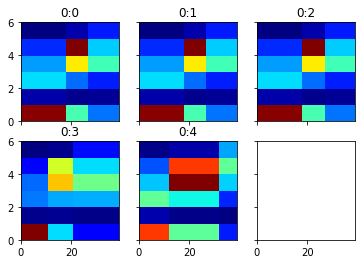

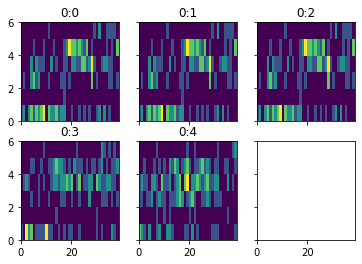

In [2]:
firing_params = dict(
        n_nrns = 7,
        n_trials = 5,
        n_states = 3,
        duration = 1000,
        min_duration = 200,
        ceil_p = 0.1,
        jitter_p = 0.2,
        bin_size = 25
        )

fit_params = dict(
        n_fit = int(1e5),
        n_samples = 2000
)

data_array, true_r, true_tau, state_inds, trial_p = fake_poisson_firing(**firing_params)

trial_count = 5
trial_inds = np.random.choice(np.arange(firing_params['n_trials']),5)
vz.firing_overview(true_r[trial_inds]);
vz.firing_overview(data_array[trial_inds], cmap='viridis');

In [3]:
hierarchical_model = return_hierarchical_model(data_array, firing_params['n_states'])

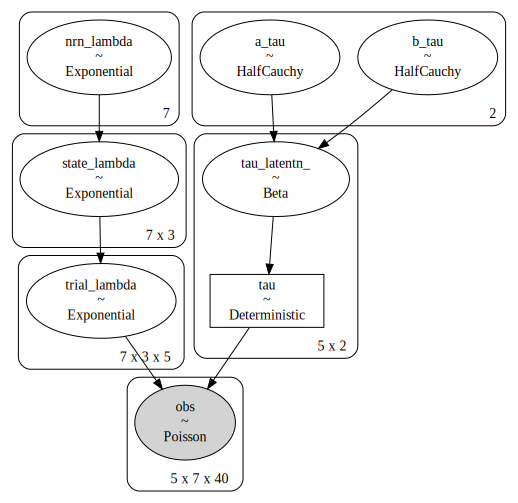

In [5]:
pm.model_to_graphviz(hierarchical_model)

In [6]:
start_t = time()
trace, approx = fit_model(hierarchical_model, **fit_params)
time_taken = time() - start_t
print(time_taken)

Finished [100%]: Average Loss = 1,365.6


In [7]:
trial_count = 5
trial_inds = np.random.choice(np.arange(firing_params['n_trials']),5, replace=False)

#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
print(mode_tau.shape)

(2000, 5, 2)
(5, 2)


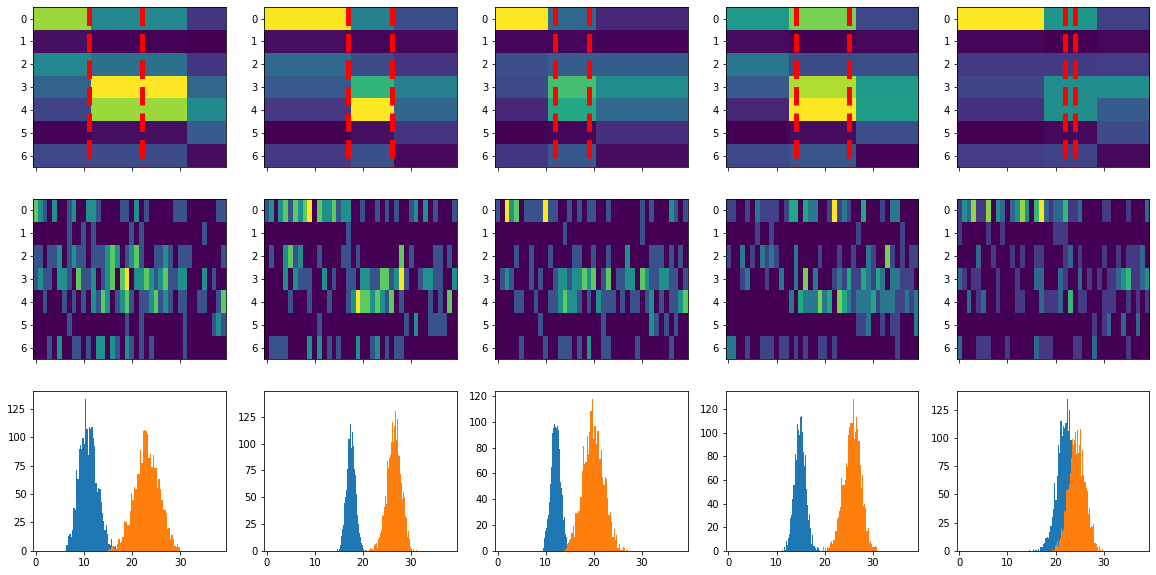

In [8]:
fig,ax = plt.subplots(3,trial_count,sharex=True,figsize=(20,10))
for trial_num,this_trial_ind in enumerate(trial_inds):
    ax[0,trial_num].imshow(true_r[this_trial_ind],aspect='auto', interpolation='nearest')
    ax[1,trial_num].imshow(data_array[this_trial_ind],aspect='auto', interpolation='nearest')
    
    for tau_num, this_tau in enumerate(tau[:,this_trial_ind].T):
        ax[2,trial_num].hist(this_tau,bins=50)
        ax[0,trial_num].vlines(mode_tau[this_trial_ind,tau_num],
                               -0.5,
                               firing_params['n_nrns']-0.5,
                               color='red',alpha=1,linewidth=5, linestyles='dashed')

In [12]:
tau_errors = np.abs(true_tau - mode_tau).flatten()
print(tau_errors)
#mean_error, std_error = tau_errors.mean(), tau_errors.std()

[1 1 0 0 5 4 2 1 0 9]


In [13]:
def firing_properties(data_array):
    # average for whole dataset
    mean_total_firing = data_array.mean(axis=None)
    # max average firing for a neuron
    max_neuron_firing = np.max(data_array.mean(axis=(0,2)))
    return mean_total_firing, max_neuron_firing

In [14]:
firing_properties(data_array)

(0.6228571428571429, 1.1)